# Emotion detection

Link to docs: https://docs.google.com/document/d/1GcE0NIkXv-lK8-hcIyUuAkVBE9Fp5wgiPiuzeH3E3hU/edit#heading=h.721u7j82jzov \\
Link to dataset: https://drive.google.com/drive/folders/1rQC98dchLiuqY7ohIkAdHXmxqGVo5FkP?usp=sharing \\
Link to paper:  https://aclanthology.org/S19-2005.pdf

### Imports

In [ ]:
# run this command, restart the colab runtime (Ctrl + M .), comment and rerun all
# !python -m spacy download en_core_web_lg

In [ ]:
import sys
import re
import urllib.request
import pkg_resources

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import spacy

!pip install symspellpy
from symspellpy import SymSpell, Verbosity
!pip install swifter
import swifter
!pip install emoji
import emoji
!pip install contractions
import contractions
!pip install num2words
from num2words import num2words
!pip install emot
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO, UNICODE_EMOJI_ALIAS, EMOJI_UNICODE, EMOJI_ALIAS_UNICODE

#!pip install pyspellchecker
#from spellchecker import SpellChecker
#
#!pip install spellwise
#from spellwise import Levenshtein, Editex, Typox
#
# import nltk
# nltk.download('words')
# word_list = nltk.corpus.words.words()

from textblob import TextBlob
from tqdm import tqdm
from typing import Iterator, List, Callable, Tuple

from google.colab import drive

In [ ]:
torch.manual_seed(115)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Data loading and exploration

In [ ]:
drive.mount('/content/gdrive', force_remount=False)

with open('/content/gdrive/MyDrive/Emotion Detection/train.txt', 'r') as file:
  train_df = pd.read_csv(file, sep='\t', header=0, index_col=0)
  print(train_df.shape)

with open('/content/gdrive/MyDrive/Emotion Detection/test.txt', 'r') as file:
  test_df = pd.read_csv(file, sep='\t', header=0, index_col=0)
  print(test_df.shape)

with open('/content/gdrive/MyDrive/Emotion Detection/dev.txt', 'r') as file:
  dev_df = pd.read_csv(file, sep='\t', header=0, index_col=0)
  print(dev_df.shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(30160, 4)
(5509, 4)
(2755, 4)


In [ ]:
train_df.head(3)

,turn1,turn2,turn3,label
id,,,,
0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others
1,When did I?,saw many times i think -_-,No. I never saw you,angry
2,By,by Google Chrome,Where you live,others


In [ ]:
test_df.head(3)

,turn1,turn2,turn3,label
id,,,,
0,Hmm,What does your bio mean?,I don’t have any bio,others
1,What you like,very little things,Ok,others
2,Yes,How so?,I want to fuck babu,others


In [ ]:
dev_df.head(3)

,turn1,turn2,turn3,label
id,,,,
0,Then dont ask me,YOURE A GUY NOT AS IF YOU WOULD UNDERSTAND,IM NOT A GUY FUCK OFF,angry
1,Mixed things such as??,the things you do.,Have you seen minions??,others
2,Today I'm very happy,and I'm happy for you ❤,I will be marry,happy


#### Let's see some stats

In [ ]:
# compute column with number of total words
train_df["num_words"] = sum([train_df[col].apply(lambda x: len(x.split(' '))) for col in ["turn1", "turn2", "turn3"]])

# averge number of words
print("average number of words:", train_df.num_words.mean())

# longest sample
print("---------------------------------------------------")
print("longest sample:", train_df.num_words.max(), "words")
print(train_df.iloc[train_df.num_words.idxmax()])
print("---------------------------------------------------")

# shortest sample
print("---------------------------------------------------")
print("shortest sample:", train_df.num_words.min(), "words")
print(train_df.iloc[train_df.num_words.idxmin()])
print("---------------------------------------------------")

average number of words: 13.579741379310345
---------------------------------------------------
longest sample: 164 words
turn1                                     What is your phone 😬
turn2               I don't know because no one ever calls me.
turn3        Is it just seems like the way I can get it to ...
label                                                   others
num_words                                                  164
Name: 21328, dtype: object
---------------------------------------------------
---------------------------------------------------
shortest sample: 3 words
turn1           Nop
turn2            ok
turn3           Hey
label        others
num_words         3
Name: 179, dtype: object
---------------------------------------------------


#### Checking average number of emojis and emotes

In [ ]:
def count_emojis(text):
  emojis = re.finditer(r'[\u263a-\U0001f645]', text)
  emoticons = re.finditer(r'(?::|;|=)(?:-)?(?:\)|\(|D|P|\*)', text)
  return sum(1 for _ in emoticons) + sum(1 for _ in emojis)

In [ ]:
def add_num_emojis_col(df):
  df["num_emojis"] = sum([df[col].apply(count_emojis) for col in ["turn1", "turn2", "turn3"]])
  df["num_emojis"] = df["num_emojis"].fillna(0) 

In [ ]:
add_num_emojis_col(train_df)
add_num_emojis_col(dev_df)

# average number of emojis
print("average number of emojis train:", train_df.num_emojis.mean())
print("average number of emojis dev:", dev_df.num_emojis.mean())

average number of emojis train: 0.5214854111405836
average number of emojis dev: 0.32087114337568057


#### Average length based on emotion

We can see that happy people tend do use more emojis, while angry people smash their keyboard in an attempt to fix their frustrations

In [ ]:
grp_df = train_df.groupby(["label"])[["num_words", "num_emojis"]].mean()
grp_df

,num_words,num_emojis
label,,
angry,15.150381,0.326734
happy,13.363893,1.363893
others,13.044287,0.263179
sad,13.629508,0.770273


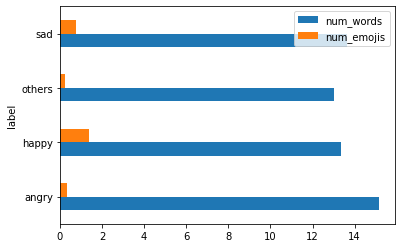

In [ ]:
grp_df.plot.barh()

### Preprocessing pipeline

##### Utils

In [ ]:
# replace numbers with words (ex.: 700 -> seven hundred)
def replace_numbers(text):
  return re.sub(r'\d+', lambda x: num2words(x.group(), lang='en'), text)

In [ ]:
# removing any leftover links
def remove_links(text):
  return re.sub(r'http\S+', ' ', text)

In [ ]:
# change code here if you want to change what the emojis will be mapped to
# :-)   =>   Happy face
# :)    =>   Happy face or smiley
# 😂   =>   smiley face with tears of joy
all_emoji_emoticons = {**UNICODE_EMOJI, **EMOTICONS_EMO, **UNICODE_EMOJI_ALIAS, **EMOJI_UNICODE, **EMOJI_ALIAS_UNICODE}
# for some reason ';‑)' and this ';-)' are different 2h of debugging :(
all_emoji_emoticons = {k.replace('‑', '-').replace(';', ';'):v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}
# fixing issues by hand 
all_emoji_emoticons[u'=('] = "Big Sad"
all_emoji_emoticons[u';('] = "Sad Wink"
all_emoji_emoticons[u'=P'] = "Tongue sticking out, cheeky, playful or blowing a raspberry" # only for small p apparently
all_emoji_emoticons[u';P'] = "Wink, Tongue sticking out, cheeky, playful or blowing a raspberry"
all_emoji_emoticons[u';p'] = "Wink, Tongue sticking out, cheeky, playful or blowing a raspberry"

# find emojis and emotes and convert them to text
def convert_emojis_and_emoticons(text):
  out = emoji.get_emoji_regexp().sub(lambda x : all_emoji_emoticons[x.group()] if x.group in all_emoji_emoticons.keys() else emoji.demojize(x.group()), text)
  out = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P|\*)', lambda x : all_emoji_emoticons[x.group()], out)
  return out

In [ ]:
print(hex(ord('‑')), "why would someone do something like this", hex(ord('-')))

0x2011 why would someone do something like this 0x2d


In [ ]:
# remove extra white spaces
def normalize_whitespace(text):
  out = re.sub(r"//t", r"\t", text)
  out = re.sub(r"( )\1+", r"\1", out)
  out = re.sub(r"(\n)\1+", r"\1", out)
  out = re.sub(r"(\r)\1+", r"\1", out)
  out = re.sub(r"(\t)\1+", r"\1", out)
  return out.strip(" ")

In [ ]:
# expander (we're - > we are)
# TODO: better expansion taking into account context??
def expand(text):
  return ' '.join([contractions.fix(token) for token in text.split(' ')])

In [ ]:
# Let's try to correct some words 
# ref: https://symspellpy.readthedocs.io/en/latest/index.html
# fastest tool out there. the rest would take 30m+ 

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_words(text):
  return sym_spell.lookup_compound(text, max_edit_distance=2, transfer_casing=False)[0].term

In [ ]:
# Tokenizer
nlp = spacy.load('en_core_web_lg', disable=['tagger', 'parser', 'ner'])
nlp.tokenizer = spacy.tokenizer.Tokenizer(nlp.vocab)

def tokenize(text):
  return [token.text for token in nlp(text)]

#### Applying the pipeline and checking the results

In [ ]:
def apply_pipeline(df):
  df["corpus"] = df.turn1 + " " + df.turn2 + " " + df.turn3
  df["corpus"] = (df["corpus"].apply(replace_numbers)
                              .apply(remove_links)
                              .apply(convert_emojis_and_emoticons)
                              .apply(normalize_whitespace)
                              .apply(expand))
  df["corpus"] = df["corpus"].swifter.apply(correct_words) # we try to speed up those two
  df["corpus"] = df["corpus"].swifter.apply(tokenize)      # bad boys 

In [ ]:
apply_pipeline(train_df)
train_df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


Pandas Apply:   0%|          | 0/30160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30160 [00:00<?, ?it/s]

,turn1,turn2,turn3,label,corpus
id,,,,,
0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others,"[do, not, worry, i, am, girl, hmm, how, do, i,..."
1,When did I?,saw many times i think -_-,No. I never saw you,angry,"[when, did, i, saw, many, times, i, think, no,..."
2,By,by Google Chrome,Where you live,others,"[by, by, google, chrome, where, you, live]"


In [ ]:
apply_pipeline(dev_df)
dev_df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


Pandas Apply:   0%|          | 0/2755 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2755 [00:00<?, ?it/s]

,turn1,turn2,turn3,label,corpus
id,,,,,
0,Then dont ask me,YOURE A GUY NOT AS IF YOU WOULD UNDERSTAND,IM NOT A GUY FUCK OFF,angry,"[then, do, not, ask, me, you, are, a, guy, not..."
1,Mixed things such as??,the things you do.,Have you seen minions??,others,"[mixed, things, such, as, the, things, you, do..."
2,Today I'm very happy,and I'm happy for you ❤,I will be marry,happy,"[today, i, am, very, happy, and, i, am, happy,..."


### Creating the vocab

In [ ]:
vocab = list(set([item for sublist in dev_df.corpus.append(train_df.corpus).tolist() for item in sublist]))
vocab.append("<pad>")

In [ ]:
vocab_idx = {}
for i, word in enumerate(vocab):
  vocab_idx[word] = i

### Loading GloVe embeddings

In [ ]:
# if this works fine try with a bigger dictionary?
# glove repo: https://github.com/stanfordnlp/GloVe
#urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')
#!unzip "/content/glove.6B.zip" -d "/content/"

embedd_dict = {}
with open('/content/glove.6B.300d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embedd_dict[word]=vector

In [ ]:
# Getting as many words as possible
# all_sentences = dev_df.corpus.append(train_df.corpus).tolist()
# 100 seems decent for vector embedding length
# ft_model = FastText(sentences=all_sentences, size=256, window=5, min_count=1, workers=4, sg=1)

In [ ]:
label_index = {
    "others": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3
}
NUM_CLASSES = len(label_index)

### Creating the Dataset and Dataloader

In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, df, avg=True, max_len=None):
    self.labels = torch.tensor([label_index[label] for label in df.label])

    if avg:
      self.data = torch.tensor([self.get_avg(corpus) for corpus in df.corpus])
    else:
      corpus = [self.pad_sequence(corp, max_len) for corp in df.corpus]
      self.data = torch.tensor([[vocab_idx[word]for word in corp] for corp in corpus])
      #self.data = [self.pad_sequence(torch.tensor([embedd_dict[word] for word in corpus if word in embedd_dict]), max_len) for corpus in df.corpus]
  
  def pad_sequence(self, sequence, max_len):
    seq_len = len(sequence)

    if seq_len > max_len:
      return sequence[:max_len]
    else:
      return np.append(sequence, ['<pad>'] * (max_len - seq_len))

  def get_avg(self, corpus):
    return np.mean([embedd_dict[word] for word in corpus if word in embedd_dict], axis=0)

  def __getitem__(self, index):
    return self.data[index], self.labels[index]

  def __len__(self):
    return len(self.labels)

#### DataLoader params

In [ ]:
BATCH_SIZE = 32
SHUFFLE = True
DROP_LAST = True

In [ ]:
train_dataset = EmotionDataset(train_df)
dev_dataset = EmotionDataset(dev_df)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, drop_last=DROP_LAST)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, drop_last=DROP_LAST)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


### Training and validation utils

In [ ]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
  model.to(device)
  model.train()
  
  epoch_accuracy = 0.0
  epoch_loss = 0.0
  num_batches = len(train_dataloader)

  for features, labels in train_dataloader:
    features = features.to(device)
    labels = labels.to(device)

    model.zero_grad()

    output = model(features)
    output = output.squeeze()
    loss = loss_crt(output, labels.squeeze())

    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()

    pred = output.argmax(dim=1, keepdim=True)
    epoch_accuracy += pred.eq(labels.view_as(pred)).float().mean().item()

  epoch_loss = epoch_loss/num_batches
  epoch_accuracy = 100. * epoch_accuracy/num_batches
  return epoch_loss, epoch_accuracy

In [ ]:
def eval_epoch(model, val_dataloader, loss_crt, device):
    model.to(device)
    model.eval()

    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(val_dataloader)

    with torch.no_grad():
        for features, labels in val_dataloader:
          features = features.to(device)
          labels = labels.to(device)

          output = model(features)
          output = output.squeeze()
          loss = loss_crt(output, labels.squeeze())

          epoch_loss += loss.item()

          pred = output.argmax(dim=1, keepdim=True)
          epoch_accuracy += pred.eq(labels.view_as(pred)).float().mean().item()

    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches

    return epoch_loss, epoch_accuracy

In [ ]:
def plot_val_loss(train_losses, val_losses, train_accuracies, val_accuracies):
  plt.figure()
  plt.plot(train_losses, label='train_loss', color='red')
  plt.plot(val_losses, label='val_loss', color='blue')
  plt.legend()
  plt.show()
  plt.plot(train_accuracies, label='train_accuracy', color='red')
  plt.plot(val_accuracies, label='val_accuracy', color='blue')
  plt.legend()
  plt.show()

In [ ]:
def train(model, device, num_epochs, train_dataloader, dev_dataloader, optimizer, loss_criterion):
  model.to(device)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  for epoch in range(1, num_epochs+1):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, loss_criterion, optimizer, device)
    val_loss, val_accuracy = eval_epoch(model, dev_dataloader, loss_criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print('\nEpoch %d'%(epoch))
    print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
    print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

  return train_losses, val_losses, train_accuracies, val_accuracies

### Baseline Model: (one hidden-layer MLP)

In [ ]:
class OneHidden(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.hidden_layer = nn.Linear(input_size, hidden_size)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.activation(self.dropout(self.hidden_layer(x)))

    return self.linear(x)

In [ ]:
one_hidden_model = OneHidden(input_size=300, hidden_size=1024, output_size=NUM_CLASSES)

num_params = 0
print("Model's parameters: ")
for n, p in one_hidden_model.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Model's parameters: 
	 hidden_layer.weight :  torch.Size([1024, 300])
	 hidden_layer.bias :  torch.Size([1024])
	 linear.weight :  torch.Size([4, 1024])
	 linear.bias :  torch.Size([4])
Number of model parameters:  312324


#### Training of the baseline model

In [ ]:
one_hidden_model.to(device)

optimizer = torch.optim.Adam(params=one_hidden_model.parameters(), lr=1e-5, weight_decay=2e-6)
loss_criterion = nn.CrossEntropyLoss()
# try other optim params
# f1 on others on train and eval, and avg f1

train_losses, val_losses, train_accuracies, val_accuracies = train(one_hidden_model, device, 10, train_dataloader, dev_dataloader, optimizer, loss_criterion)


Epoch 1
train loss: 1.23242899, accuracy: 49.42940552
val loss: 0.83751388, accuracy: 84.92005814

Epoch 2
train loss: 1.13762429, accuracy: 51.11464968
val loss: 0.77178485, accuracy: 85.31976744

Epoch 3
train loss: 1.06388315, accuracy: 55.35098195
val loss: 0.74652901, accuracy: 84.30232558

Epoch 4
train loss: 1.00807031, accuracy: 58.16746285
val loss: 0.71419454, accuracy: 83.61191860

Epoch 5
train loss: 0.96333000, accuracy: 60.55268047
val loss: 0.69564606, accuracy: 82.73982558

Epoch 6
train loss: 0.92916828, accuracy: 62.30095541
val loss: 0.66773751, accuracy: 82.66715116

Epoch 7
train loss: 0.89975409, accuracy: 63.68099788
val loss: 0.65585202, accuracy: 82.44912791

Epoch 8
train loss: 0.87563758, accuracy: 64.88521762
val loss: 0.66230340, accuracy: 81.10465116

Epoch 9
train loss: 0.85379095, accuracy: 65.83731423
val loss: 0.64410556, accuracy: 80.95930233

Epoch 10
train loss: 0.83573682, accuracy: 66.55719214
val loss: 0.63290933, accuracy: 81.57703488


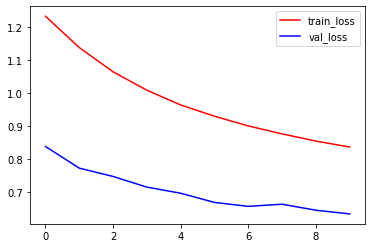

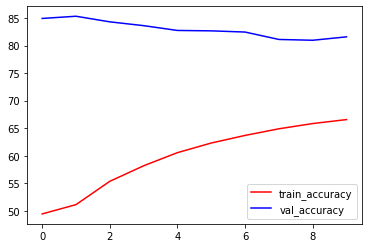

In [ ]:
plot_val_loss(train_losses, val_losses, train_accuracies, val_accuracies)

### LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, drop_prob: float, embedding_flag: bool, vocab: int = None):
      super().__init__()

      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.drop_prob = drop_prob 
      self.embedding_flag = embedding_flag

      self.embedding = nn.Embedding(len(vocab), input_size)

      if embedding_flag:  # copy glove embeddings where the word is found
        embedd_matrix = self.embedding.weight.detach().numpy()
        embedd_index = 0
        for word in vocab:
          if word in embedd_dict:
            embedd_matrix[embedd_index] = embedd_dict[word]
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedd_matrix).float())

      self.lstm = nn.LSTM(
              input_size=input_size, 
              hidden_size=hidden_size, 
              batch_first=True,
        )
      self.dropout = nn.Dropout(drop_prob)
      self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
      x = self.embedding(x)
      # x has shape: batch_size x timesteps x 300
      # h has shape:  D X batch_size X hidden_size (batch_size=len(x), D=1)

      _, h_n = self.lstm(x)

      output_scores = self.output_layer(self.dropout(h_n[0]))

      return output_scores

In [ ]:
lstm_model = LSTMModel(
    input_size=300,
    hidden_size=512,
    output_size=NUM_CLASSES,
    drop_prob=0.4,
    embedding_flag=False,
    vocab=vocab
)

num_params = 0
print("Model's parameters: ")
for n, p in lstm_model.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Model's parameters: 
	 embedding.weight :  torch.Size([10547, 300])
	 lstm.weight_ih_l0 :  torch.Size([2048, 300])
	 lstm.weight_hh_l0 :  torch.Size([2048, 512])
	 lstm.bias_ih_l0 :  torch.Size([2048])
	 lstm.bias_hh_l0 :  torch.Size([2048])
	 output_layer.weight :  torch.Size([4, 512])
	 output_layer.bias :  torch.Size([4])
Number of model parameters:  4833224


#### Training of the LSTM Model

In [ ]:
train_dataset = EmotionDataset(train_df, avg=False, max_len=100)
dev_dataset = EmotionDataset(dev_df, avg=False, max_len=100)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=SHUFFLE, drop_last=DROP_LAST)
dev_dataloader = DataLoader(dev_dataset, batch_size=16, shuffle=SHUFFLE, drop_last=DROP_LAST)

In [ ]:
print(next(iter(train_dataloader))[0].shape)

torch.Size([16, 100])


In [ ]:
optimizer = torch.optim.Adam(params=lstm_model.parameters(), lr=1e-2, weight_decay=1e-4)
loss_criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train(lstm_model, device, 20, train_dataloader, dev_dataloader, optimizer, loss_criterion)


Epoch 1
train loss: 1.37652297, accuracy: 43.50132626
val loss: 0.94732569, accuracy: 84.84738372

Epoch 2
train loss: 1.35942011, accuracy: 44.95358090
val loss: 1.14869626, accuracy: 62.75436047

Epoch 3
train loss: 1.16377642, accuracy: 55.40119363
val loss: 0.84407236, accuracy: 73.47383721

Epoch 4
train loss: 0.88832604, accuracy: 68.60742706
val loss: 0.53320195, accuracy: 84.12063953

Epoch 5
train loss: 0.69034077, accuracy: 76.62466844
val loss: 0.42205880, accuracy: 86.80959302

Epoch 6
train loss: 0.59265153, accuracy: 79.90053050
val loss: 0.53971850, accuracy: 81.57703488

Epoch 7
train loss: 0.52798185, accuracy: 82.28448276
val loss: 0.45524716, accuracy: 83.82994186

Epoch 8
train loss: 0.49667047, accuracy: 83.02718833
val loss: 0.42898978, accuracy: 86.30087209

Epoch 9
train loss: 0.48688288, accuracy: 83.41180371
val loss: 0.37411807, accuracy: 87.31831395

Epoch 10
train loss: 0.45108816, accuracy: 84.71816976
val loss: 0.37906986, accuracy: 86.62790698

Epoch 11

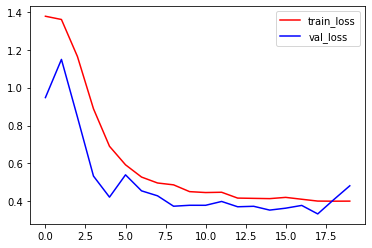

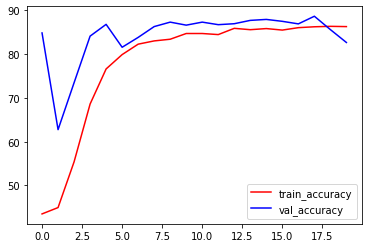

In [ ]:
plot_val_loss(train_losses, val_losses, train_accuracies, val_accuracies)

#### Training of the LSTM Model with it's own embeddings

In [ ]:
lstm_model_embedd = LSTMModel(
    input_size=300,
    hidden_size=512,
    output_size=NUM_CLASSES,
    drop_prob=0.4,
    embedding_flag=True,
    vocab=vocab
)

num_params = 0
print("Model's parameters: ")
for n, p in lstm_model_embedd.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Model's parameters: 
	 embedding.weight :  torch.Size([10547, 300])
	 lstm.weight_ih_l0 :  torch.Size([2048, 300])
	 lstm.weight_hh_l0 :  torch.Size([2048, 512])
	 lstm.bias_ih_l0 :  torch.Size([2048])
	 lstm.bias_hh_l0 :  torch.Size([2048])
	 output_layer.weight :  torch.Size([4, 512])
	 output_layer.bias :  torch.Size([4])
Number of model parameters:  4833224


In [ ]:
optimizer = torch.optim.Adam(params=lstm_model_embedd.parameters(), lr=1e-2, weight_decay=1e-4)
loss_criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train(lstm_model_embedd, device, 20, train_dataloader, dev_dataloader, optimizer, loss_criterion)


Epoch 1
train loss: 1.33297824, accuracy: 45.21551724
val loss: 0.69425614, accuracy: 85.71947674

Epoch 2
train loss: 1.03744343, accuracy: 59.54575597
val loss: 0.90350593, accuracy: 63.51744186

Epoch 3
train loss: 0.91589429, accuracy: 65.23541114
val loss: 0.60446310, accuracy: 82.04941860

Epoch 4
train loss: 0.88375465, accuracy: 66.54509284
val loss: 0.47083158, accuracy: 86.77325581


In [ ]:
plot_val_loss(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
import gc
gc.collect()